### Solid Waste Engineering 2018
#### Semester project: Testing the probability of garbage
Masters students in Environmental Engineering from the [École Polytechnique Féderale de Lausanne](https://enac.epfl.ch/environmental-engineering) test the hypothesis that litter densities on Lac Léman are predicatable.  The current method is based on the Probability Density Function derived from the logarithm of the pieces/meter of trash (pcs/m) from over 100 samples.

This workbook is an initiation to standard techniques:

1. Getting data from the API or other remote sources
2. Sorting, grouping and slicing the data
3. Using lists and dictionairies to slice and sort data
4. Mergiing dataFrames

We will add to this workbook as the semester advances

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import os
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import requests
import json

### This is all the daily totals in the database for Lac Léman:

In [3]:
url = "http://mwshovel.pythonanywhere.com/dirt/daily-total/Lac-Léman/?format=json"
data = requests.get(url).json()

In [4]:
this_data = pd.DataFrame(data)

In [5]:
this_data["pcs_m"]=this_data.total / this_data.length

In [6]:
this_data.columns

Index(['date', 'length', 'location', 'total', 'pcs_m'], dtype='object')

### This is just the record to Tiger-duck-beach
#### extracted from the data frame

In [7]:
tigerDuck = this_data[this_data.location == "Tiger-duck-beach"]

In [8]:
tigerDuck

,date,length,location,total,pcs_m
146,2018-10-16,18,Tiger-duck-beach,1387,77.055556


### This is the object totals for Tiger-duck-beach

In [9]:
urlx = "http://mwshovel.pythonanywhere.com/dirt/codes/Tiger-duck-beach/?format=json"
datax = requests.get(urlx).json()

In [10]:
tiger_luck_code = pd.DataFrame(datax)

In [11]:
tiger_luck_code[:5]

,code_id,date,length,location_id,owner,project_id,quantity
0,G200,2018-10-16,18,Tiger-duck-beach,mwshovel,tiger-duck,51
1,G178,2018-10-16,18,Tiger-duck-beach,mwshovel,tiger-duck,9
2,G70,2018-10-16,18,Tiger-duck-beach,mwshovel,tiger-duck,4
3,G28,2018-10-16,18,Tiger-duck-beach,mwshovel,tiger-duck,1
4,G34,2018-10-16,18,Tiger-duck-beach,mwshovel,tiger-duck,4


### This gets the MLW codes from the website:

In [12]:
csvUrl = "https://mwshovel.pythonanywhere.com/static/newCriteria.csv"
mlwCodes = pd.read_csv(csvUrl)

In [13]:
mlwCodes[:10]

,code,material,description,source
0,G1,Plastic,Six pack rings,Food
1,G2,None,None,None
2,G3,Plastic,Shopping bags,Household
3,G4,Plastic,Freezer bags,Household
4,G5,Plastic,Generic plastic bags,Household
5,G6,None,None,None
6,G7,Plastic,Drink bottles < 0.5l,Food
7,G8,Plastic,Drink bottles > 0.5l,Food
8,G9,Plastic,Cleaner bottles,Household
9,G10,Plastic,Food containers,Food


### So if you wanted to get just the codes that are plastic:

In [14]:
plasticCodes = mlwCodes.loc[mlwCodes.material == 'Plastic']

In [15]:
print(len(plasticCodes), len(mlwCodes))

89 213


### What are the codes from tiger-duck-beach that were indentified and are plastic?

1. What is the desctiption of each code
2. Merge the quantity and description in one dataframe

In [16]:
# create a list of the codes that are just plastic
plasticList = plasticCodes.code.tolist()
plasticList[:5]

['G1', 'G3', 'G4', 'G5', 'G7']

In [17]:
# use that list to select only those codes from the inventorY
tigerDuckBeachPlastic = tiger_luck_code[tiger_luck_code['code_id'].isin(plasticList)]
# this result should be set to a copy otherwise it will put out an error warning:
justCodeQauntity=tigerDuckBeachPlastic[['location_id', 'code_id', 'quantity']].copy()
# now the column can be renamed so it can be merged later:
justCodeQauntity.rename(columns={'code_id':'code'}, inplace=True)
justCodeQauntity[:5]

,location_id,code,quantity
2,Tiger-duck-beach,G70,4
3,Tiger-duck-beach,G28,1
4,Tiger-duck-beach,G34,4
5,Tiger-duck-beach,G24,19
6,Tiger-duck-beach,G21,38


In [18]:
# the results can now be used to get the details (material, source, decription) from the mlwCodes data
# make a list from the inventory and apply to the mlwCodes dataframe
tigerDuckPlasticCodes = justCodeQauntity.code.tolist()
tigerDuckBeachPlasticCodes = mlwCodes[mlwCodes.code.isin(tigerDuckPlasticCodes)]
tigerDuckBeachPlasticCodes[:5]

,code,material,description,source
20,G21,Plastic,Drink lids,Food
22,G23,Plastic,Lids unidentified,Household
23,G24,Plastic,Plastic rings from lids,Food
26,G27,Plastic,Cigarette butts,Tobaco
27,G28,Plastic,Pens and lids,Household


In [19]:
tigerDuckBeachQtyDescPlastic = pd.merge(tigerDuckBeachPlasticCodes,  justCodeQauntity, on = "code", how='left')
tigerDuckBeachQtyDescPlastic[:5]
# we should write a function that does that whole process!

,code,material,description,source,location_id,quantity
0,G21,Plastic,Drink lids,Food,Tiger-duck-beach,38
1,G23,Plastic,Lids unidentified,Household,Tiger-duck-beach,21
2,G24,Plastic,Plastic rings from lids,Food,Tiger-duck-beach,19
3,G27,Plastic,Cigarette butts,Tobaco,Tiger-duck-beach,177
4,G28,Plastic,Pens and lids,Household,Tiger-duck-beach,1


### Of the 89 possible plastic objects that are included in the MLW codes how many were indenditified at tiger-duck-beach?

In [20]:
numberPlasticCategories = len(tigerDuckBeachPlastic)
numberPlasticCategories

24

### How does this result compare to other locations on Lac Léman?

1. Here we need to get all the code data for the lake
2. Group by location 
3. Select only those items that are plastic

In [21]:
# get all the code values for the lake
urlLac = "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/?format=json"
dataLac = requests.get(urlLac).json()

In [22]:
# make a data frame and eliminate tiger-duck-beach
# if we wanted we could also select only codes that are 'plastic'
# do that later
dfLacX = pd.DataFrame(dataLac)
dfLac = dfLacX[dfLacX.location_id != "Tiger-duck-beach"]

In [23]:
# take a look at the columns:
dfLac.columns

Index(['code_id', 'date', 'length', 'location_id', 'owner', 'project_id',
       'quantity'],
      dtype='object')

In [24]:
# for now we don't need the project or the owner:
dfLac = dfLac[['date', 'location_id', 'code_id', 'quantity', 'length']]
# just need the plastic codes:
dfLacPlastic = dfLac[dfLac['code_id'].isin(plasticList)]

In [54]:
dfLacPlasticGrouped = pd.DataFrame(dfLacPlastic['quantity'].groupby([dfLacPlastic['location_id'],dfLacPlastic['date'], dfLacPlastic['code_id']]).sum())
# dfLacPlasticGrouped[:29] <---- uncomment this to see the results
# this is just one of many ways to group with pandas
# below we get the count of MLW codes indetified in each survey:
counts = dfLacPlasticGrouped.groupby(['location_id', 'date']).count()
counts[:10]

quantity
location_id     date                
Anarchy-Beach   2018-04-02        28
Arabie          2016-01-24        32
                2016-04-02        22
                2016-08-25        29
                2017-02-16        21
                2018-05-08        16
Bain-des-Dames  2016-03-26        29
                2017-05-19        21
                2018-07-22        23
Baye-de-Clarens 2015-11-24        19

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd50460f780>]],
      dtype=object)

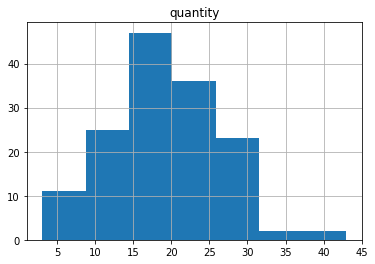

In [55]:
# throw that into a histogram to see how the results from tiger-duck-beach compare
# remember there were 24 MLW codes indetified
counts.hist(bins=7)

### So the number of different categories indentified on tiger-duck-beach is in the third quartile or right around what would we would expect to find based on previous results